<a href="https://colab.research.google.com/github/OlivierNDO/image_proc/blob/master/Image_Augmentation_Demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import Packages

In [1]:
import datetime
import skimage
import gc
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import pickle as pkl
from operator import itemgetter
import os
import random
from skimage import io
from skimage.transform import resize
from sklearn.metrics import precision_score, recall_score, confusion_matrix, auc, roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.python.client import device_lib
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization, GlobalAvgPool2D
from tensorflow.keras.layers import Add, ZeroPadding2D, AveragePooling2D, GaussianNoise, SeparableConv2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.layers import add
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import LearningRateScheduler, ReduceLROnPlateau
from keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
import time
from tqdm import tqdm, tqdm_notebook
from functools import partial
from PIL import ImageStat, Image
import os
import logging
from google.cloud import storage
import cv2
from io import BytesIO

Define Functions

In [2]:
def rand_crop_arr(arr, perc_pixels = 0.15) :
    """
    Crop the left or right <perc_pixels> from a 3d numpy array
    > left or right is chosen randomly
    """
    arr_copy = arr.copy()
    side_choice = random.choice([0,1,2,3])
    if side_choice == 0:
        crop_coord = arr_copy.shape[0] - int(arr_copy.shape[0] * perc_pixels)
        arr_copy[crop_coord:,:] = np.mean(arr_copy)
    elif side_choice == 1:
        crop_coord = 0 + int(arr_copy.shape[0] * perc_pixels)
        arr_copy[:crop_coord,:] = np.mean(arr_copy)
    elif side_choice == 2:
        crop_coord = arr_copy.shape[1] - int(arr_copy.shape[1] * perc_pixels)
        arr_copy[:,crop_coord:,] = np.mean(arr_copy)
    else:
        crop_coord = 0 + int(arr_copy.shape[1] * perc_pixels)
        arr_copy[:,:crop_coord,] = np.mean(arr_copy)
    return arr_copy


def random_coords_zoom(arr, zoom_perc = 0.7):
    """
    Zoom in on <zoom_perc> of numpy 3d array image
    """
    chunk_size = int(arr.shape[0] * zoom_perc)
    arr_copy = arr.copy()
    pt_a = random.sample(range(0, arr.shape[0] - chunk_size - 1), 1)[0]
    pt_b = pt_a + chunk_size
    pt_c = random.sample(range(0, arr.shape[1] - chunk_size), 1)[0]
    pt_d = pt_c + chunk_size
    return resize(arr_copy[pt_a:pt_b, pt_c:pt_d], (arr_copy.shape[0], arr_copy.shape[0]))



def rand_coords_missing(arr, n_chunks = 10, chunk_size = 20):
    """
    Fill random square chunks of picture with noise based on the batch mean and standard deviation
    """    
    arr_copy = arr.copy()
    for i in range(n_chunks):
        pt_a = random.sample(range(chunk_size, arr.shape[0]), 1)[0]
        pt_b = pt_a + chunk_size
        pt_c = random.sample(range(chunk_size, arr.shape[1]), 1)[0]
        pt_d = pt_c + chunk_size
        arr_copy[pt_a:pt_b, pt_c:pt_d] = np.mean(arr_copy)
    return arr_copy

def color_distort_arr(arr):
    """
    Distort rgb ratio of numpy array
    """
    arr_copy = arr.copy()
    color_to_distort = random.choice([0,1,2])
    arr_copy[:,:,color_to_distort] *= np.random.normal(1,.15,1)[0]
    return arr_copy


def np_array_to_batch_gen_aug(x_arr, batch_size = 5):
    """
    Create Keras generator objects for minibatch training
        > apply mild color distortion and rotation to every image
        > every second array is flipped horizontally
        > every fifth array has 10 random 20 x 20 chunks filled with mean color
        > every ninth array has 70% zoom applied on random coordinates
        > every seventh array has a 15% crop of the left, right, bottom or top
        > every eleventh array is flipped vertically
    Args:
        x_arr: array of predictors
        y_arr: array of targets
        batch_size: size of minibatches
    """
    indices = np.arange(len(x_arr))
    x_array_list = []
    batch_list = []
    while True:
            np.random.shuffle(indices) 
            for i in indices:
                batch_list.append(i)
                if len(batch_list)==batch_size:
                    x_arr_aug = np.array([color_distort_arr(x) for x in x_arr[batch_list]])
                    x_arr_aug = np.array([np.fliplr(x) if (j//2) == (j/2) else x for j, x in enumerate(x_arr_aug)])
                    x_arr_aug = np.array([rand_coords_missing(x) if (j//5) == (j/5) else x for j, x in enumerate(x_arr_aug)])
                    x_arr_aug = np.array([rand_crop_arr(x) if (j//7) == (j/7) else x for j, x in enumerate(x_arr_aug)])
                    x_arr_aug = np.array([np.flipud(x) if (j//11) == (j/11) else x for j, x in enumerate(x_arr_aug)])
                    x_arr_aug = np.array([random_coords_zoom(x) if (j//9) == (j/9) else x for j, x in enumerate(x_arr_aug)])
                    #yield x_arr_aug, y_arr[batch_list]
                    x_array_list.append(x_arr_aug)
                    batch_list=[]
    return x_array_list

def read_resize_image(img, img_type = 'file', img_height = 220, img_width = 220):
      """Read image (url or file path) and resize"""
      if img_type == 'url':
          img_load = Image.open(BytesIO(requests.get(img).content))
      elif img_type == 'file':
          img_load = tf.keras.preprocessing.image.load_img(img)
      else:
          print('Error: Attribute img_type must be "url" or "file"')
      resized_img = skimage.transform.resize(np.array(img_load),  (img_height, img_width))
      return np.expand_dims(np.array(resized_img), axis = 0)


def augment_array(x_arr):
  x_arr_aug = np.array([color_distort_arr(x) for x in x_arr])
  x_arr_aug = np.array([np.fliplr(x) if (j//2) == (j/2) else x for j, x in enumerate(x_arr_aug)])
  x_arr_aug = np.array([rand_coords_missing(x) if (j//5) == (j/5) else x for j, x in enumerate(x_arr_aug)])
  x_arr_aug = np.array([rand_crop_arr(x) if (j//7) == (j/7) else x for j, x in enumerate(x_arr_aug)])
  x_arr_aug = np.array([np.flipud(x) if (j//8) == (j/8) else x for j, x in enumerate(x_arr_aug)])
  x_arr_aug = np.array([random_coords_zoom(x) if (j//9) == (j/9) else x for j, x in enumerate(x_arr_aug)])
  return x_arr_aug

Read and Resize Image Files

In [3]:
image_filenames = [f'image_data/{x}' for x in os.listdir('image_data/') if '.jpg' in x]
y = [s.split('image_data/')[1].split('.')[0][:-1] for s in image_filenames]
image_array = np.vstack([read_resize_image(img = x) for x in image_filenames])

Augment Ten Images

In [4]:
augmented_image_array = augment_array(x_arr = image_array)

Plot Original vs. Augmented Images

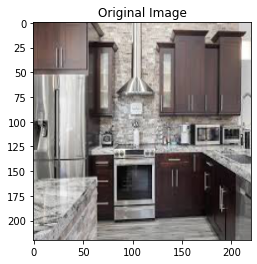

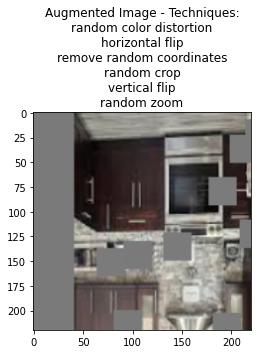

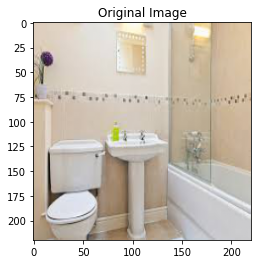

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


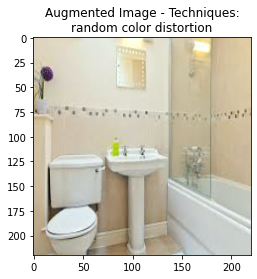

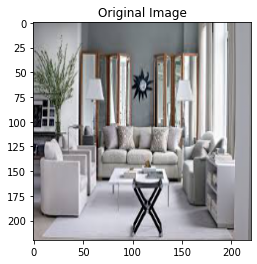

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


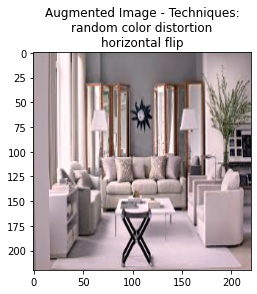

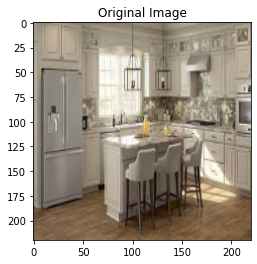

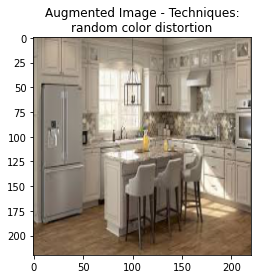

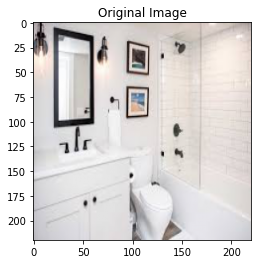

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


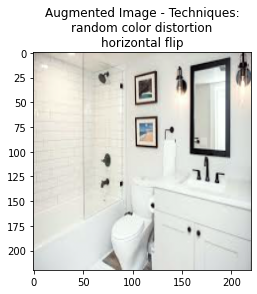

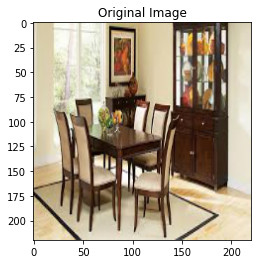

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


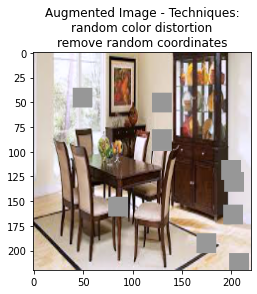

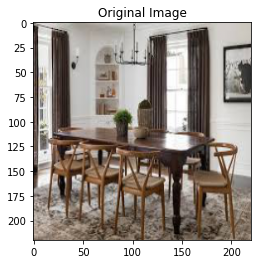

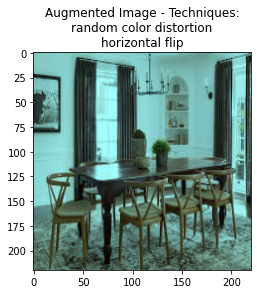

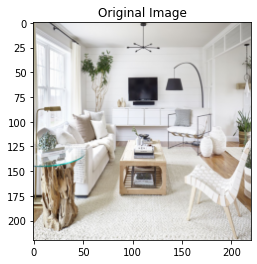

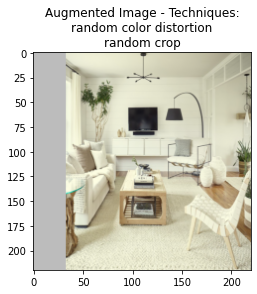

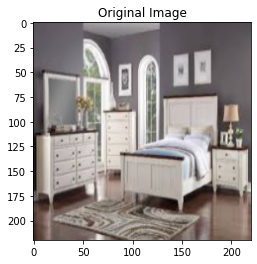

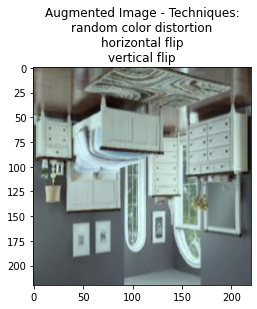

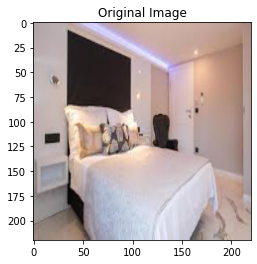

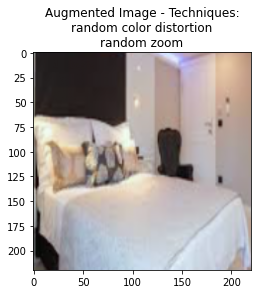

In [5]:
for i in range(image_array.shape[0]):
  techniques = ['random color distortion']
  if i % 2 == 0:
    techniques.append('horizontal flip')
  if i % 5 == 0:
    techniques.append('remove random coordinates')
  if i % 7 == 0:
    techniques.append('random crop')
  if i % 8 == 0:
    techniques.append('vertical flip')
  if i % 9 == 0:
    techniques.append('random zoom')

  technique_string = '\n'.join(techniques)

  plt.figure()
  plt.imshow(image_array[i])
  plt.title('Original Image')
  plt.show()
  plt.figure()
  plt.imshow(augmented_image_array[i])
  plt.title('Augmented Image - Techniques:' + '\n' + technique_string)
  plt.show()

Demonstrate Each Augmentation Function

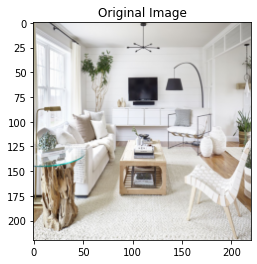

In [6]:
original_image = image_array[7]
plt.imshow(original_image)
plt.title('Original Image')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


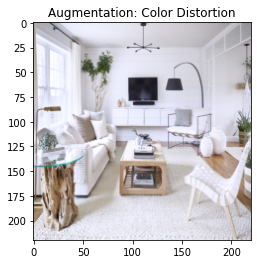

In [7]:
plt.imshow(color_distort_arr(image_array[7]))
plt.title('Augmentation: Color Distortion')
plt.show()

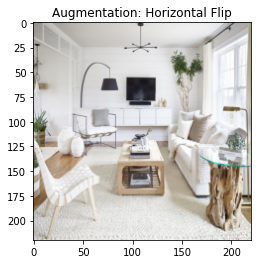

In [8]:
plt.imshow(np.fliplr(image_array[7]))
plt.title('Augmentation: Horizontal Flip')
plt.show()

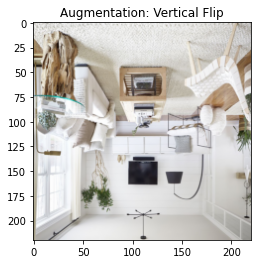

In [9]:
plt.imshow(np.flipud(image_array[7]))
plt.title('Augmentation: Vertical Flip')
plt.show()

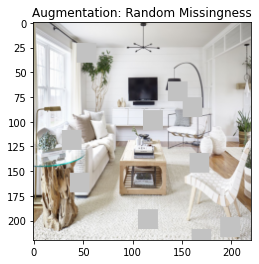

In [10]:
plt.imshow(rand_coords_missing(image_array[7]))
plt.title('Augmentation: Random Missingness')
plt.show()

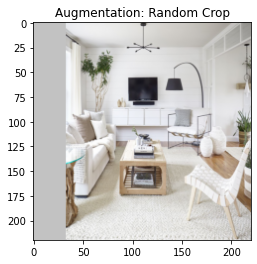

In [11]:
plt.imshow(rand_crop_arr(image_array[7]))
plt.title('Augmentation: Random Crop')
plt.show()

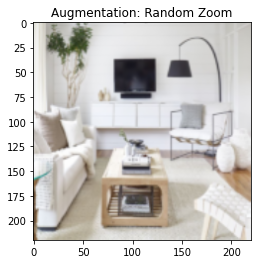

In [12]:
plt.imshow(random_coords_zoom(image_array[7]))
plt.title('Augmentation: Random Zoom')
plt.show()